## Training

In [4]:
# Import Libraries

import matplotlib.pyplot as plt
import torch
import torchvision
import os

from torch import nn
from torchvision import transforms
from helper_functions import set_seeds

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import engine
from torchinfo import summary
from helper_functions import plot_loss_curves

In [5]:
# Set cuda usage
# If cuda not available, cpu will be use for training
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [6]:
# Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT 

# Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False
    
# Get Images Classes
class_names = os.listdir('D:/waste classification/split_dataset/train/')

# Change the classifier head 
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

In [7]:
# Print a summary using torchinfo
summary(model=pretrained_vit, 
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 6]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [8]:
# Setup training and testing data directory paths

train_dir = 'D:/waste classification/split_dataset/train/'
test_dir = 'D:/waste classification/split_dataset/val/'

Best practice when using pretrained model is to always remember to transform/format the custom data in the same way the original data model was trained on.

In [9]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


Once the data is transformed, we can turn othe images into DataLoaders using the create_dataloaders()

In [10]:
NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [12]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)


In [13]:

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), 
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

d:\vision_transformer_image_classification_transfer_learning\vitenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [06:18<56:46, 378.46s/it]

Epoch: 1 | train_loss: 0.8476 | train_acc: 0.7204 | test_loss: 0.5447 | test_acc: 0.8384


 20%|██        | 2/10 [12:51<51:37, 387.25s/it]

Epoch: 2 | train_loss: 0.4226 | train_acc: 0.8647 | test_loss: 0.4633 | test_acc: 0.8655


 30%|███       | 3/10 [19:28<45:40, 391.44s/it]

Epoch: 3 | train_loss: 0.3437 | train_acc: 0.8910 | test_loss: 0.4237 | test_acc: 0.8753


 40%|████      | 4/10 [25:56<39:00, 390.10s/it]

Epoch: 4 | train_loss: 0.2839 | train_acc: 0.9180 | test_loss: 0.4096 | test_acc: 0.8666


 50%|█████     | 5/10 [32:21<32:21, 388.39s/it]

Epoch: 5 | train_loss: 0.2405 | train_acc: 0.9326 | test_loss: 0.3913 | test_acc: 0.8714


 60%|██████    | 6/10 [38:52<25:57, 389.30s/it]

Epoch: 6 | train_loss: 0.2076 | train_acc: 0.9429 | test_loss: 0.3800 | test_acc: 0.8809


 70%|███████   | 7/10 [44:37<18:44, 374.85s/it]

Epoch: 7 | train_loss: 0.1829 | train_acc: 0.9526 | test_loss: 0.3744 | test_acc: 0.8834


 80%|████████  | 8/10 [50:20<12:08, 364.45s/it]

Epoch: 8 | train_loss: 0.1652 | train_acc: 0.9575 | test_loss: 0.3650 | test_acc: 0.8834


 90%|█████████ | 9/10 [56:14<06:01, 361.24s/it]

Epoch: 9 | train_loss: 0.1484 | train_acc: 0.9658 | test_loss: 0.3601 | test_acc: 0.8795


100%|██████████| 10/10 [1:02:43<00:00, 376.35s/it]

Epoch: 10 | train_loss: 0.1347 | train_acc: 0.9722 | test_loss: 0.3621 | test_acc: 0.8853


In [16]:
# Specify where you would like to save your model
PATH = "vit_trash_classification_model2.pt"

# Saving the Model
torch.save(pretrained_vit, PATH)

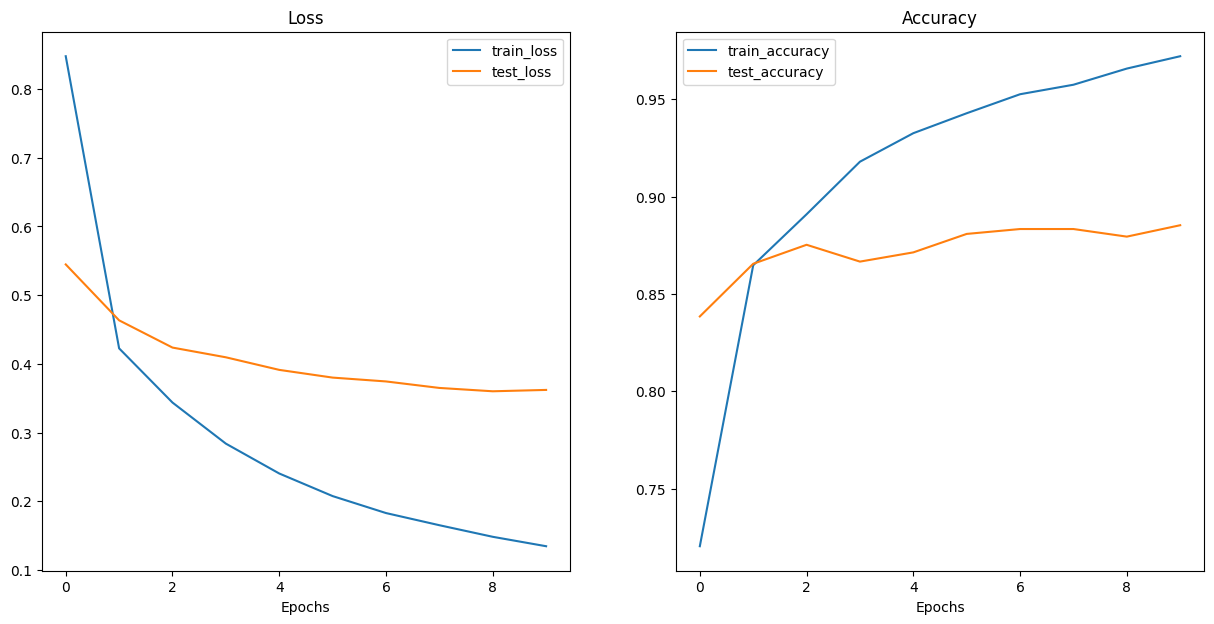

In [15]:
# Plot the loss curves

plot_loss_curves(pretrained_vit_results) 

# Testing

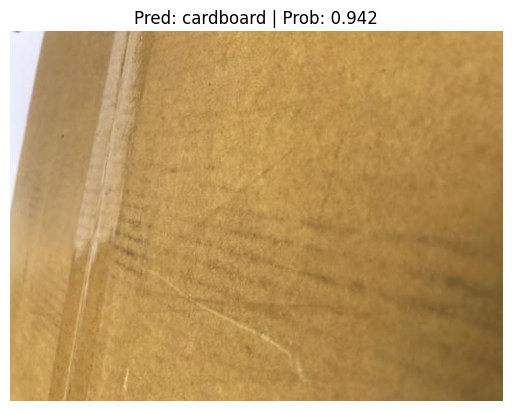

In [20]:
import requests

# Import function to make predictions on images and plot them 
#from going_modular.going_modular.predictions 
from predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = 'D:/waste classification/split_dataset/val/cardboard/cardboard9.jpg'

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

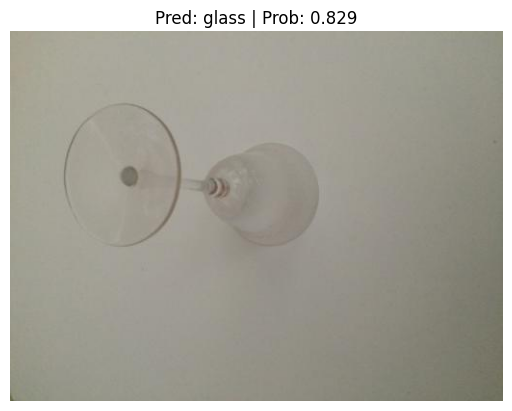

In [21]:
# Setup custom image path
custom_image_path = 'D:/waste classification/split_dataset/val/glass/glass12.jpg'

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

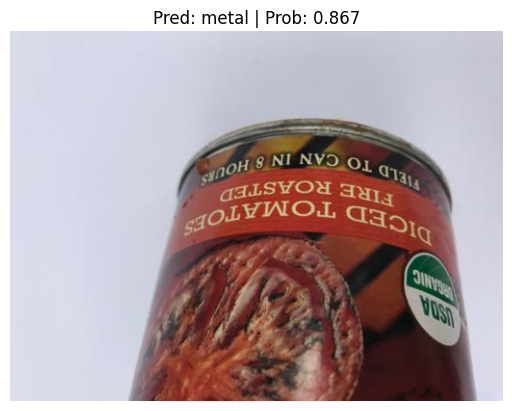

In [22]:
# Setup custom image path
custom_image_path = 'D:/waste classification/split_dataset/val/metal/metal23.jpg'

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

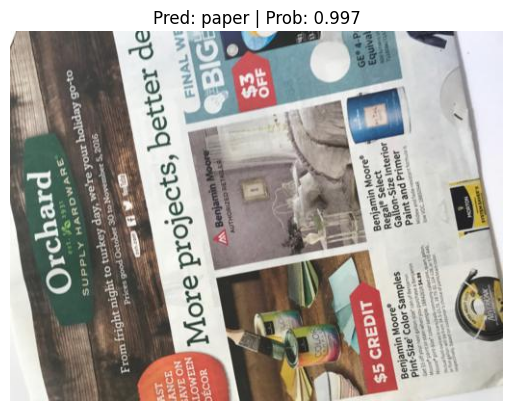

In [24]:
# Setup custom image path
custom_image_path = 'D:/waste classification/split_dataset/val/paper/paper83.jpg'

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

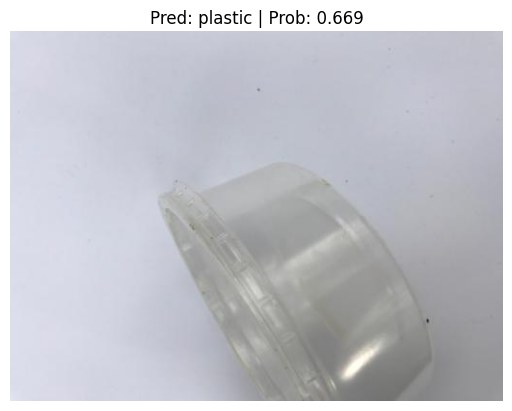

In [25]:
# Setup custom image path
custom_image_path = 'D:/waste classification/split_dataset/val/plastic/plastic45.jpg'

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

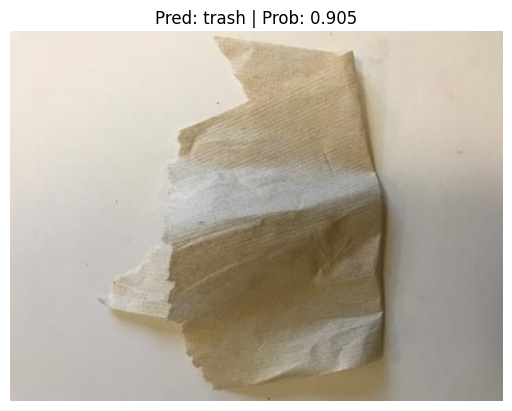

In [26]:
# Setup custom image path
custom_image_path = 'D:/waste classification/split_dataset/val/trash/trash56.jpg'

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)